**Name: Zahra Dehghanian**

**Student ID: 401300417**

In this practical assignment, we will develope a U-Net for semantis segmentation of lung CT-scans.

For this task, you will use a dataset consisting of CT-scans from lungs of COVID-19 patients. The regions affected by COVID-19 are marked with labels of ground glass opacity. You will be training and testing the U-Net model on this dataset.

## Imports

In [17]:
# Import any needed packages here
import torch
import numpy as np
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
import cv2
from torch import nn
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image

## Prepare Data
Now download and unzip the data. (Note: If you face any problems for downloading uzing gdown and unzipping, you may also download the data manually using the Goggle Drive links in the code)

In [8]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [9]:
import zipfile

zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/images.zip", "r")
zip_ref.extractall()
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/masks.zip", "r")
zip_ref.extractall()
zip_ref.close()
images = np.load('images_medseg.npy').astype(np.float32)
masks = np.load('masks_medseg.npy').astype(np.float32)

In [10]:
print("Images Shape:", images.shape)
print("Masks Shape:", masks.shape)

Images Shape: (100, 512, 512, 1)
Masks Shape: (100, 512, 512, 4)


The dataset consists of 100 CT images with size 512*512. In the Masks data,for each image 4 masks are provided with different meanings. The first mask (index 0) is the ground glass opacity class, indicating the regions affected by COVID-19. Also, the last mask (index 4) is the background class.

You can see the visulaiztion of a few of the CT images, and their given masks using the code below. In this assignment, use the first mask (ground glass opacity) for the segmentation task (You may also test it on other classes if you like too!)

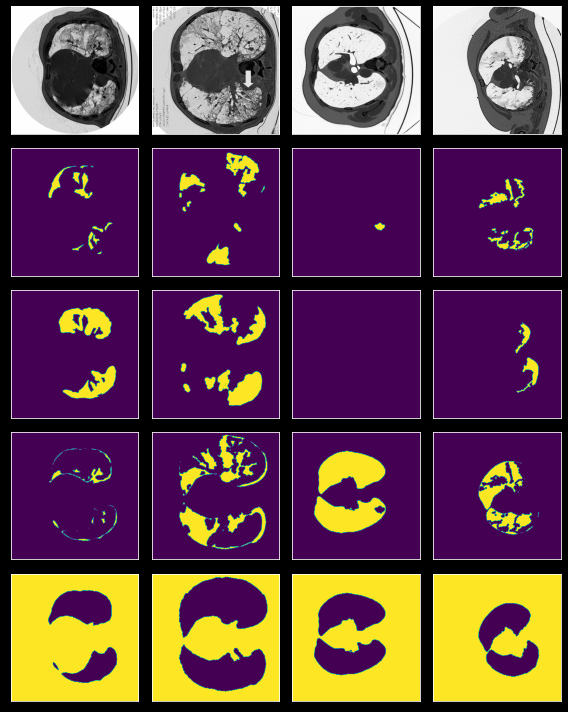

In [13]:
import matplotlib.pyplot as plt

plt.style.use("dark_background")

def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=4):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))
    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap="Greys")
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    #print(j)
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()


visualize(images, masks)

## Create Your Dataset Class (10%)

In [18]:
class Normalize(object):
    def __init__(self,mean,std):
        self.transform = transforms.Normalize(mean, std)
    def __call__(self, sample):
        img, label = sample
        return self.transform(img),label

class ToTensor(object):
    def __init__(self):
        pass
    def __call__(self, sample):
        img, label = sample
        label = np.array(label)/255
        img = np.array(img)
        img = (img-img.min())/(img.max()-img.min())
        return torch.from_numpy(img.transpose((2, 0, 1))).float(),torch.from_numpy(label.copy()).long()

class Resize(object):
    def __init__(self,arg):
        self.transform_img = transforms.Resize(arg,Image.BILINEAR)
        self.transform_label = transforms.Resize(arg,Image.NEAREST)

    def __call__(self, sample):
        img, label = sample
        return self.transform_img(img),self.transform_label(label)


transform = transforms.Compose([
        Resize((224,224)),ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])


/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [19]:
class CovidCTDataset(Dataset):

    def __init__(self, images,masks, transforms):
        self.images = images
        self.masks = masks
        self.transform = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = self.images[idx]
        label = self.masks[idx]
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img = Image.fromarray(np.uint8(img*255)).convert('RGB')
        if self.transform:
            img,label = self.transform((img,label))
        sample = {'img': img,
                  'label': label}
        return sample


covidDataset = CovidCTDataset(images,masks,transform)


## Split Dataset and Dataloader (5%)

In this part, split the dataset (80% train, 10% validation, 10% test). Then, create your train and validation DataLoader, using random shuffle and batch size of 4.

In [ ]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

batch_size = 8
train_split = 0.8
valid_split = 0.1

# Create indices for the split
dataset_size = len(covidDataset)
train_size = int(train_split * dataset_size)
valid_size = int(valid_split * dataset_size)
test_size =  dataset_size - train_size - valid_size

# Split the train and validation data and create dataloaders
train_dst,valid_dst,test_dst = random_split(covidDataset, [train_size,valid_size, test_size])

train_loader = DataLoader(train_dst,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_dst,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dst,batch_size=batch_size,shuffle=True)


## Implement your U-Net (45%)

In this section implement your U-Net model, inherited from torch.nn.Module.

In the next text cell, explain the architecture of the implemented U-Net. Then, complete the code cell to creat your class.

In this part we implement a Unet with 4 contraction and expandition block. here we use the structure explained bellow for each block.  
contract block contains : conv2d => batchNorm2d => Relu => conv2d => batchNorm2d => Relu => Maxpool2d

expand block contains : conv2d => batchNorm2d => Relu => conv2d => batchNorm2d => Relu => ConvTranspose2d

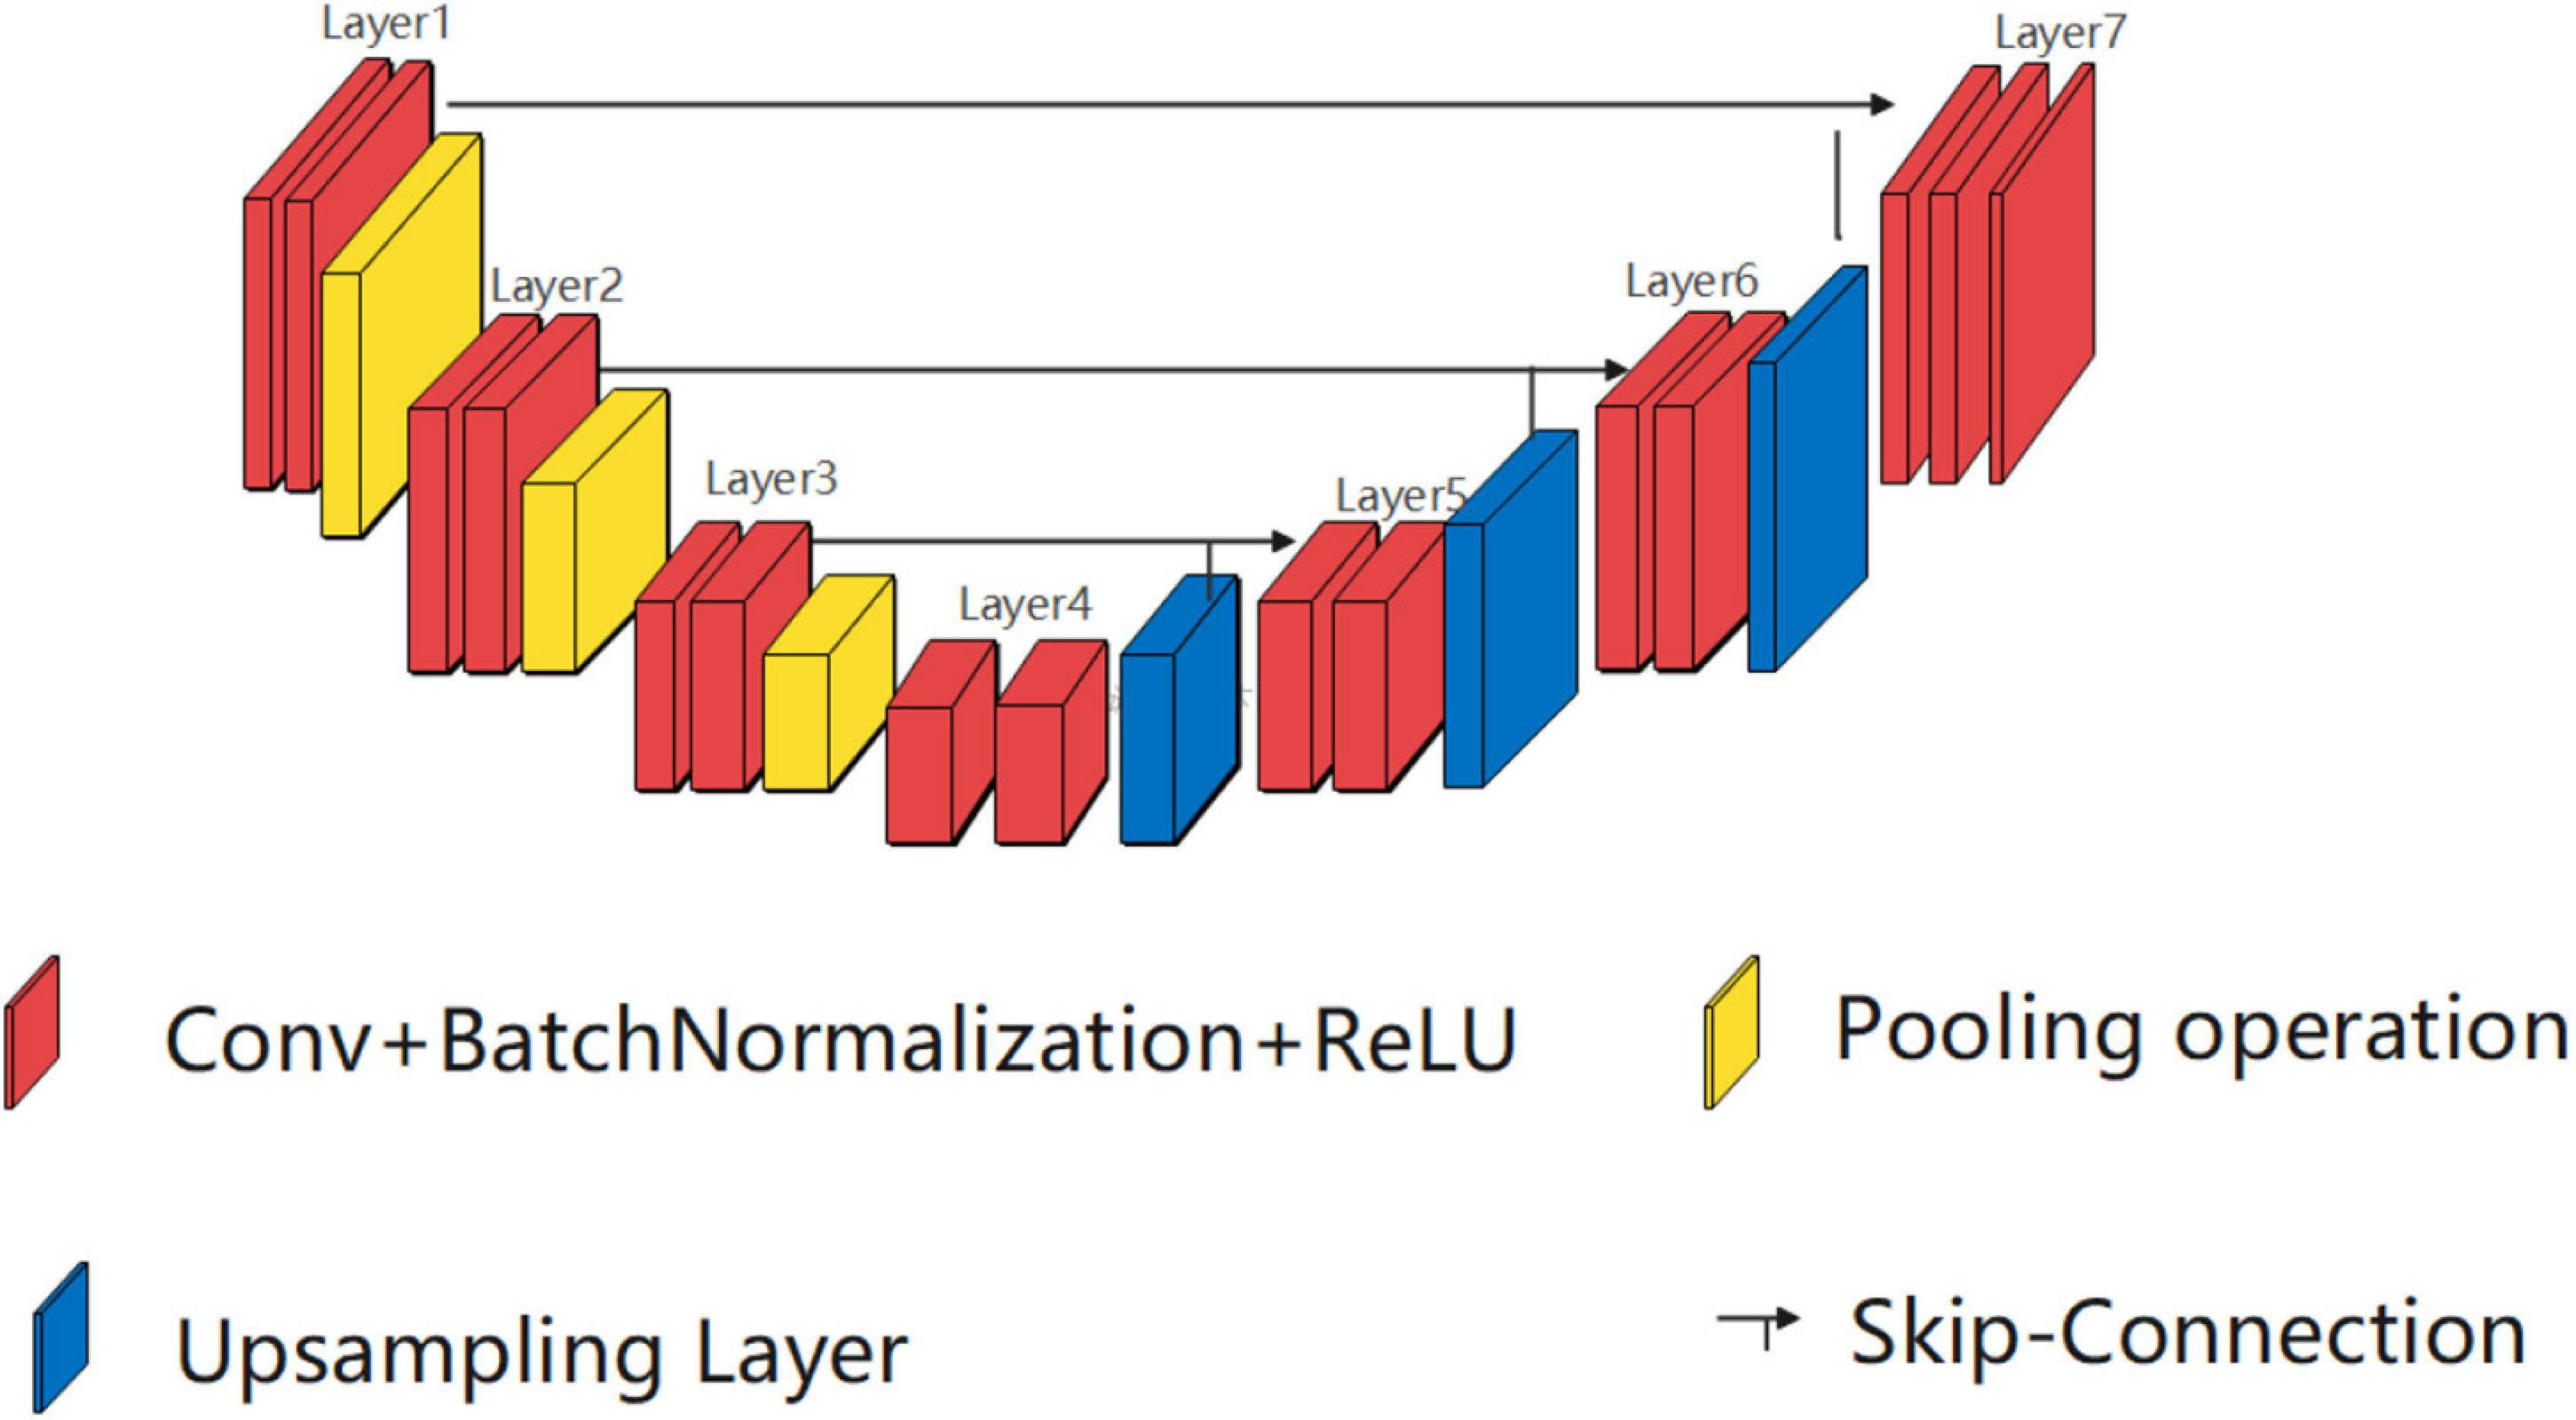

In [ ]:
class UNET(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)
        self.conv4 = self.contract_block(128, 256, 3, 1)
        self.upconv4 = self.expand_block(256, 128, 3, 1)
        self.upconv3 = self.expand_block(128*2, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def contract_block(self, in_channels, out_channels, kernel_size, padding):
        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )
        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):
        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

    def forward(self, x):
        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv3(conv3)
        # upsampling part
        upconv4 = self.upconv4(conv4)
        upconv3 = self.upconv3(torch.cat([upconv4, conv3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))
        return upconv1

In [ ]:
class UNet(nn.Module):
    def __init__(self, channels_in, num_classes):
        super(UNet, self).__init__()
        # TODO: Initialize the model
        

    def forward(self, x):
      # TODO: Implement the forward function  
      return None

## IOU (5%)
In this section, implement the function calculating IOU (Intersection Over Union) for a given prediction (your model's output) and target (ground-truth labels).

In [ ]:
def IoU(output, target):
  # TODO: Implement IOU
  Return None

## Define your model, optimizer, and loss function (5%)

Instantiate your model. Also, set your optimizer to Adam optimizer, and your criterion to Bincry Cross-Entropy Loss.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = None
model.to(device)
optimizer = None
criterion = None

## Train and test function (25%)

Train your model for a desired number of epochs (at least 15). At each epoch, run your model on the validation data (reporting the loss and IOU value), and save the model which has the best average IOU on the validation set. Finally, report the average IOU on the target data.

During training, also plot the train loss values, average IOU on the train data, and avergae IOU on the validation data per epochs.

In [ ]:
def train(model, train_dataloader, validation_dataloader, num_epochs):
    # TODO: Implement your train function here.


def test(model, test-dataloader):
    # TODO: Implement your test function here.  
            

In [ ]:
# TODO: run the train and test functions and draw the required outputs.
# To get the full point from this part, you should get IOU above 0.9

## Visualize the models output on 4 of target images (5%)

Run the model on 4 samples from the target set. Visualize the outcome by plotting the groud-truth labels, model's predicition, and the difference between them.

In [ ]:
# TODO: Run the model on 4 samples from target set, Visualize the labels and predictions, and compare them

## Improve U-Net (Bonus) (10%)

In this bnous part, you can add your ideas for improving your model's performance. As an idea, you can search about exploiting IOU metric in the loss function. (you may use other ideas as well!) 

In [ ]:
# TODO: Improve U-NET